# VOLVE WAVELET ESTIMATION

## Author: J. Romero

In this report we are going to estimate the wavelet of the Volve dataset via two diferent methods: Spectral matching and statistical method. To start, we import the Volve Pre-Stack data and we select a single trace.

In [151]:
import warnings
warnings.filterwarnings('ignore')

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

from scipy import signal
from scipy.signal import windows
from scipy.signal import butter, lfilter, freqz, medfilt, fftconvolve
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from bruges.filters.wavelets import ormsby, ricker
from segyshot import SegyShot

In [67]:
# Input data (run dataprep.py to obtain the inputfile, and download the velfile directly from Volve village)
inputfile = '../data/ST10010_1150780_40203_2dline1.sgy'
velfile = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

f = segyio.open(inputfile, ignore_geometry=True)

In [68]:
seismic = segyio.open(inputfile, ignore_geometry=True)

In [69]:
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])

(-0.5, 39.5, 249.5, -0.5)

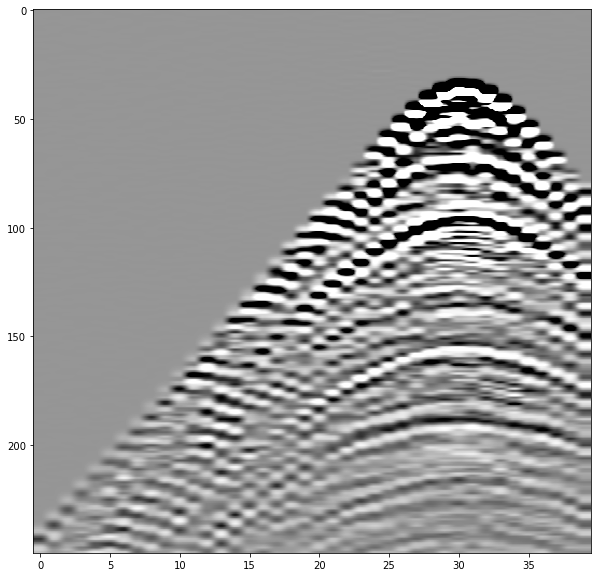

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(sg.get_shotgather(29)['VZ'].T[0:250, 130:170], cmap='Greys', vmin=-2e5, vmax=2e5)
ax.axis('tight')

In [78]:
print(segyio.tools.wrap(f.text[0]))  

C 1 CLIENT: STATOIL           COMPANY: RESERVOIR EXPLORATION TECHNOLOGY
C 2 AREA: VOLVE NORWAY BLOCK 15/9                SURVEY: ST10010
C 3 SWATH:  11                             VESSELS:M/V VIKLAND, M/V SANCO
SPIRITC 4 RCV LINE: 1150780    RCVR RANGE: 1239-1717
C 5 DATA-SET: NAV MERGE   TRACES PER RECORD: 240 X 4   SEQ: 094-133
C 6 RECORDING FORMAT: IEEE SEG-Y           FORMAT THIS REEL: SEG-Y 3592
C 7 SAMPLE CODE: FLOATING PT               PROCESSED: 03/11/2010
C 8 ACQ. GEOM: 8 ROLL 8  INLINE SWATH      LINE PREFIX: ST10010
C 9 INSTRUMENT: VECTORSEIS OCEAN BOTTOM    RECORDING SYSTEM DELAY: 0 MS
C10 RECORDING FILTER: 1.5/6-187/260MIN PHS DESCRIPTION: HZ/DB PER OCTAVE
C11 NO OF RECEIVER LINES/SWATH: 8          RECEIVER LINE SEPARATION: 400/200M
C12 ACTIVE CABLE LENGTH: 5975M             RCVRS / RCV LINE 240 X 4
C13 NO OF SOURCES:  2                      SOURCE SEPARATION: 50M
C14 RECEIVER INTERVAL: 25M                 SHOT INTERVAL: 25M, FLIP/FLOP
C15 DATUM: ED50, 31N  SPHEROID: INT. 

For frequency analysis purposes we must know the sampling interval of the seismic data. By reading the header, the sampling interval that was found was 0.002 seconds

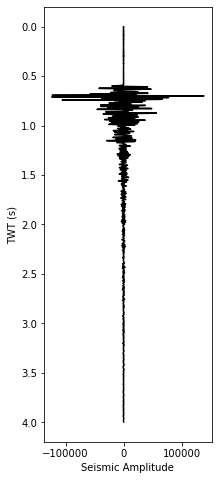

In [104]:
dt = 0.002
t = np.arange(0,sg.nt)*dt

tr = sg.get_shotgather(29)['VZ'].T[:, 200]
fig, ax = plt.subplots(figsize=(3,8))
ax.plot(tr, t, 'k')
ax.set_ylabel('TWT (s)')
ax.set_xlabel('Seismic Amplitude')
ax.invert_yaxis()

**Spectral Matching**

This technique uses the power/amplitude spectrum to analyze which are the frequencies that most contribute to the signal. If we assume that the Earth's reflectivity spectrum is flat, the spectrum of the signal is an approximate of the spectrum of the wavelet. 

First, we estimate the amplitude and power spectrum of the seismic trace previously selected of the Volve dataset.

Text(0.5, 0, 'Frequencies (Hz)')

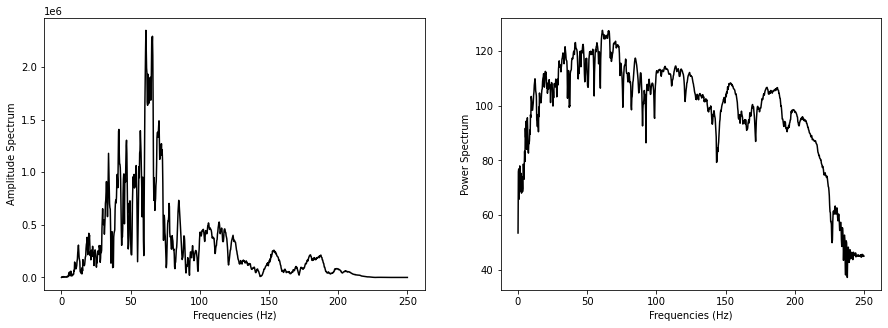

In [225]:
amp_spec = np.abs(np.fft.rfft(tr))
f = np.fft.rfftfreq(sg.nt, d=dt)
P = 20 * np.log10(amp_spec)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(f, amp_spec, 'k')
ax[0].set_ylabel('Amplitude Spectrum')
ax[0].set_xlabel('Frequencies (Hz)')

ax[1].plot(f, P, 'k')
ax[1].set_ylabel('Power Spectrum')
ax[1].set_xlabel('Frequencies (Hz)')


Ormsby wavelet is a well-known model wavelet in geophysics that relies on the definition of 4 frecuencies: low-cut frequency, low-pass frequency, high-pass frequency, and the high-cut frequency, as follows: 

$$
A(t)=\frac{\pi f_{1}^{2}}{f_{2}-f_{1}} \operatorname{sinc}^{2}\left(f_{1} t\right)-\frac{\pi f_{2}^{2}}{f_{2}-f_{1}} \operatorname{sinc}^{2}\left(f_{2} t\right)-\frac{\pi f_{3}^{2}}{f_{4}-f_{3}} \operatorname{sinc}^{2}\left(f_{3} t\right)+\frac{\pi f_{4}^{2}}{f_{4}-f_{3}} \operatorname{sinc}^{2}\left(f_{4} t\right)
$$

Where $A(t)$ is a the function (wavelet) and $f_{i}$ is each of the 4 frequecies. For the seismic trace selected from the Volve dataset these 4 frequencies were visually selected from the power spectrum: $10, 20, 60, 100$. We implemented Bruges Python library to compute the Ormsby wavelet:

In [254]:
duration = 0.200
orms = ormsby(duration, dt=dt, f=[10,20,60,100])
tw = np.arange(-len(orms)//2,len(orms)//2,1)*dt

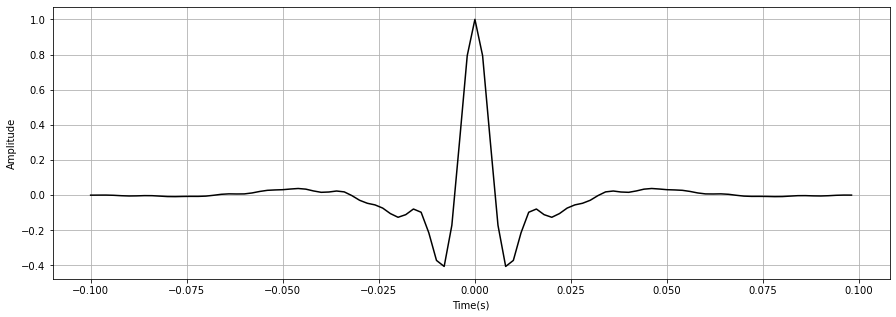

In [255]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(tw, orms, 'k')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time(s)')
ax.grid(which='both')

**Statistical Wavelet** 

To extract the statistical wavelet, we first compute the autorrelation of the seismic trace:

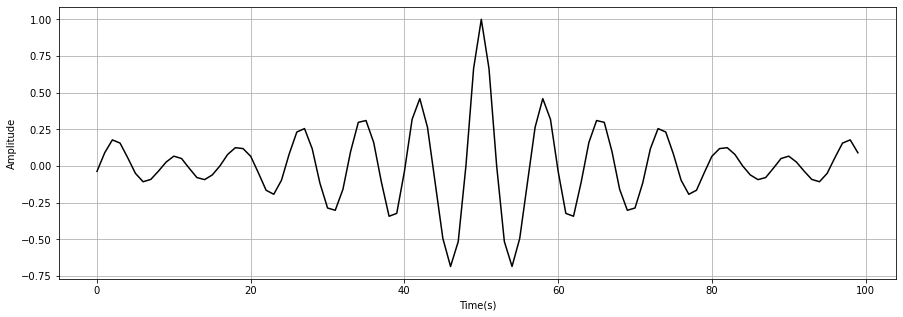

In [148]:
acorr = np.correlate(tr, tr, mode='same')
swv = acorr[sg.nt//2-50:sg.nt//2+50 ]/np.max(acorr)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot( swv, 'k')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time(s)')
ax.grid(which='both')

Then, we apply a Bartlett and a Gaussian filter (with a standard deviation of 7) to get smoother version of the wavelet:

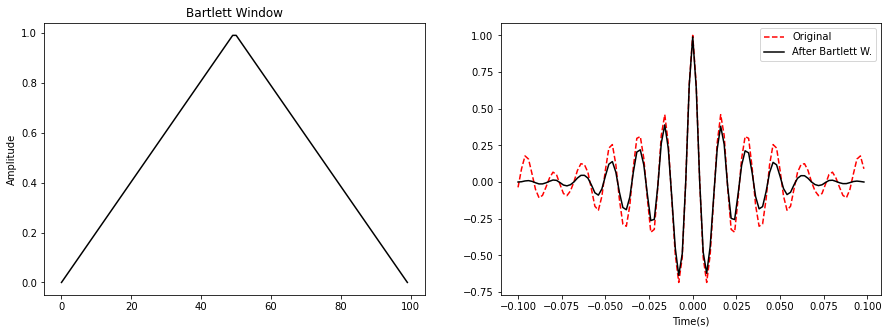

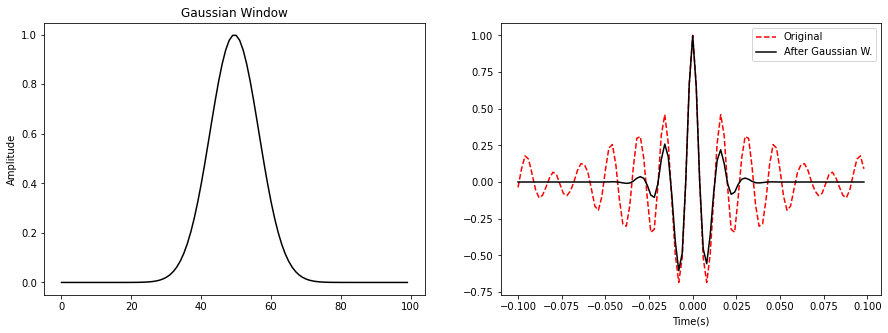

In [259]:
bartlett = windows.bartlett(100, sym=True)
gaussian = windows.gaussian(100, 7)

fbar = bartlett * swv
fgau = gaussian * swv

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(bartlett, 'k')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Bartlett Window')
ax[1].plot(tw, swv, 'r--')
ax[1].plot(tw, fbar, 'k')
ax[1].set_xlabel('Time(s)')
ax[1].legend(['Original', 'After Bartlett W.'])

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(gaussian, 'k')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Gaussian Window')
ax[1].plot(tw, swv, 'r--')
ax[1].plot(tw, fgau, 'k')
ax[1].set_xlabel('Time(s)')
ax[1].legend(['Original', 'After Gaussian W.'])

The last step is important as we are looking for a signal in which the energy concentreation ideally is centered at 0 (zero offset wavelet).

Lastly, if we compare the last three wavelets calculated:

(-0.075, 0.075)

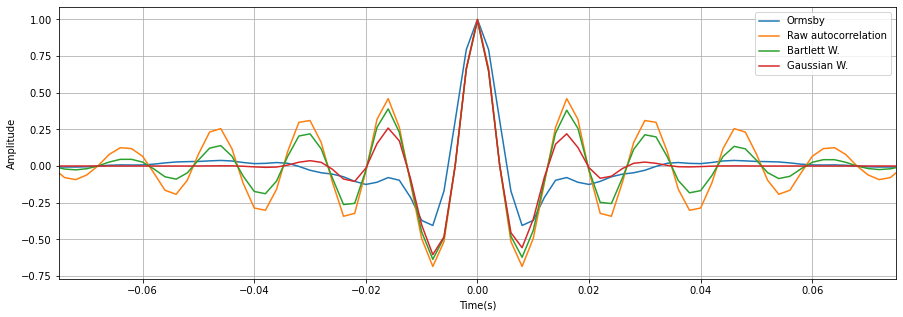

In [257]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(tw, orms)
ax.plot(tw, swv)
ax.plot(tw, fbar)
ax.plot(tw, fgau)
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time(s)')
ax.grid(which='both')
ax.legend(['Ormsby', 'Raw autocorrelation', 'Bartlett W.', 'Gaussian W.'])
ax.set_xlim([-0.075, 0.075])